**Évaluation & Synthèse du projet**

En-Nasry Salma

Ce notebook complet utilise directement les données fournies pour comparer les modèles GARCH et LSTM sur les séries S&P 500 (GSPC) et Bitcoin (BTC-USD).

***Objectif***

Comparer les performances de prévision de la volatilité entre :

un modèle GARCH

un modèle LSTM

***à l’aide de :***

MSE

RMSE

Log-Likelihood

Test de Diebold–Mariano

**Import des bibliothèques**

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy import stats

**Chargement des données**

**1 Données S&P 500 (GSPC)**

In [6]:
gspc_real = pd.read_csv("GSPC_sample.csv")
gspc_garch = pd.read_csv("GSPC_volatility_garch.csv")
gspc_lstm = pd.read_csv("GSPC_volatility_lstm.csv")


# Volatilité réalisée
vol_real_gspc = gspc_real['rv20']
vol_garch_gspc = gspc_garch['volatility_garch']
vol_lstm_gspc = gspc_lstm['volatility']

**2 Données Bitcoin (BTC-USD)**

In [7]:
btc_real  = pd.read_csv("BTC-USD_sample.csv")
btc_garch = pd.read_csv("BTCUSD_volatility_garch.csv")
btc_lstm  = pd.read_csv("BTCUSD_volatility_lstm.csv")

btc_real['date']  = pd.to_datetime(btc_real['date'])
btc_garch['date'] = pd.to_datetime(btc_garch['date'])
btc_lstm['date']  = pd.to_datetime(btc_lstm['date'])


**Alignement des données (par date)**

In [8]:
gspc = gspc_real[['date','rv20']] \
    .merge(gspc_garch[['date','volatility_garch']], on='date') \
    .merge(gspc_lstm[['date','volatility']], on='date')

btc = btc_real[['date','rv20']] \
    .merge(btc_garch[['date','volatility_garch']], on='date') \
    .merge(btc_lstm[['date','volatility']], on='date')

gspc.columns = ['date','vol_real','vol_garch','vol_lstm']
btc.columns  = ['date','vol_real','vol_garch','vol_lstm']


**Fonctions d’évaluation**


In [9]:
def calcul_mse_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mse, rmse


def log_vraisemblance(erreur):
    return -0.5 * np.sum(np.log(2 * np.pi) + erreur**2)


**Résultats quantitatifs**

**S&P 500**

In [10]:
err_garch_gspc = gspc['vol_real'] - gspc['vol_garch']
err_lstm_gspc  = gspc['vol_real'] - gspc['vol_lstm']

mse_garch_gspc, rmse_garch_gspc = calcul_mse_rmse(gspc['vol_real'], gspc['vol_garch'])
mse_lstm_gspc,  rmse_lstm_gspc  = calcul_mse_rmse(gspc['vol_real'], gspc['vol_lstm'])

ll_garch_gspc = log_vraisemblance(err_garch_gspc)
ll_lstm_gspc  = log_vraisemblance(err_lstm_gspc)

print("GSPC — GARCH | MSE:", mse_garch_gspc, "RMSE:", rmse_garch_gspc, "LL:", ll_garch_gspc)
print("GSPC — LSTM  | MSE:", mse_lstm_gspc,  "RMSE:", rmse_lstm_gspc,  "LL:", ll_lstm_gspc)


GSPC — GARCH | MSE: 2.757761350851165e-06 RMSE: 0.00166065088168801 LL: -307.8448705485916
GSPC — LSTM  | MSE: 0.0003734045334238451 RMSE: 0.01932367805113315 LL: -307.90695388291385


**Bitcoin**

In [11]:
err_garch_btc = btc['vol_real'] - btc['vol_garch']
err_lstm_btc  = btc['vol_real'] - btc['vol_lstm']

mse_garch_btc, rmse_garch_btc = calcul_mse_rmse(btc['vol_real'], btc['vol_garch'])
mse_lstm_btc,  rmse_lstm_btc  = calcul_mse_rmse(btc['vol_real'], btc['vol_lstm'])

ll_garch_btc = log_vraisemblance(err_garch_btc)
ll_lstm_btc  = log_vraisemblance(err_lstm_btc)

print("BTC — GARCH | MSE:", mse_garch_btc, "RMSE:", rmse_garch_btc, "LL:", ll_garch_btc)
print("BTC — LSTM  | MSE:", mse_lstm_btc,  "RMSE:", rmse_lstm_btc,  "LL:", ll_lstm_btc)


BTC — GARCH | MSE: 5.78550787864825e-05 RMSE: 0.007606252611272025 LL: -448.45612084310415
BTC — LSTM  | MSE: 4.465111015332136e-06 RMSE: 0.002113080929669315 LL: -448.443093690968


**Test de Diebold–Mariano**

In [12]:
def diebold_mariano(e1, e2):
    d = e1**2 - e2**2
    dm_stat = np.mean(d) / np.sqrt(np.var(d, ddof=1) / len(d))
    p_value = 2 * (1 - stats.norm.cdf(abs(dm_stat)))
    return dm_stat, p_value


In [13]:
dm_gspc, p_gspc = diebold_mariano(err_garch_gspc, err_lstm_gspc)
dm_btc,  p_btc  = diebold_mariano(err_garch_btc, err_lstm_btc)

print("DM GSPC :", dm_gspc, "| p-value :", p_gspc)
print("DM BTC  :", dm_btc,  "| p-value :", p_btc)

DM GSPC : -24.02874714201481 | p-value : 0.0
DM BTC  : 20.501030037090224 | p-value : 0.0


**Visualisations**

**S&P 500**

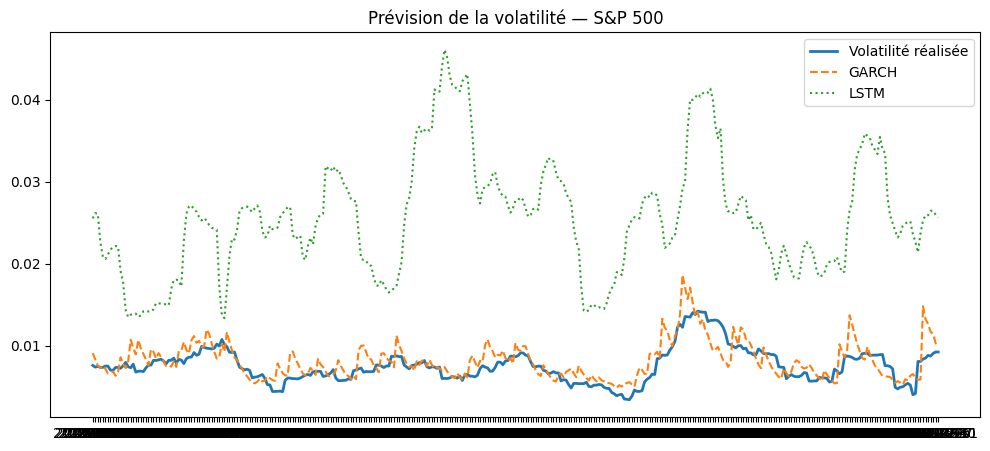

In [15]:
plt.figure(figsize=(12,5))
plt.plot(gspc['date'], gspc['vol_real'], label="Volatilité réalisée", linewidth=2)
plt.plot(gspc['date'], gspc['vol_garch'], label="GARCH", linestyle="--")
plt.plot(gspc['date'], gspc['vol_lstm'], label="LSTM", linestyle=":")
plt.title("Prévision de la volatilité — S&P 500")
plt.legend()
plt.show()

**Bitcoin**

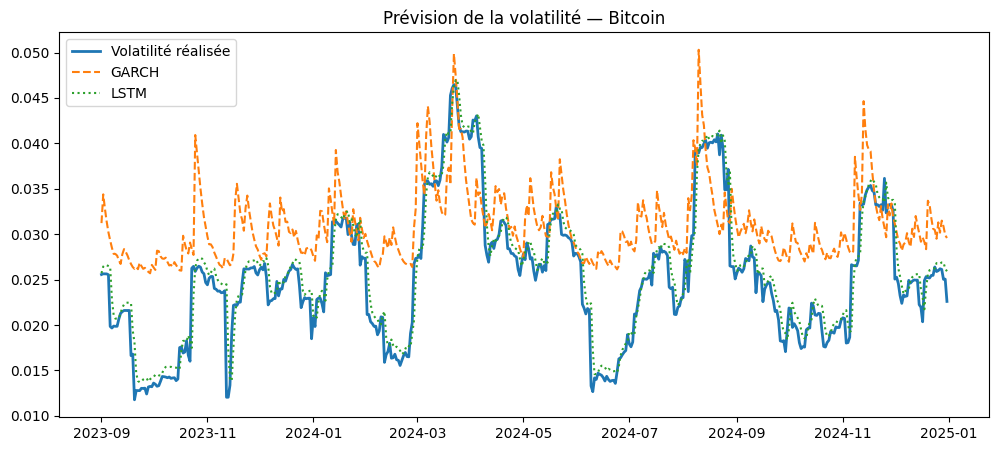

In [17]:
plt.figure(figsize=(12,5))
plt.plot(btc['date'], btc['vol_real'], label="Volatilité réalisée", linewidth=2)
plt.plot(btc['date'], btc['vol_garch'], label="GARCH", linestyle="--")
plt.plot(btc['date'], btc['vol_lstm'], label="LSTM", linestyle=":")
plt.title("Prévision de la volatilité — Bitcoin")
plt.legend()
plt.show()
